<a href="https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JoaoLages/diffusers-interpret/blob/main/notebooks/stable_diffusion_img2img_example.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Diffusion - Img2Img 🎨 

This notebook shows an example of how to run `diffusers_interpret.StableDiffusionImg2ImgPipelineExplainer` to explain `diffusers.StableDiffusionImg2ImgPipeline`.

In [1]:
!pip install -U diffusers-interpret

### 0 - Login in HuggingFace's Hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

### 1 - Initialize `StableDiffusionImg2ImgPipeline` normally

In [3]:
# make sure you're logged in by running the previous cell or `huggingface-cli login`
import torch
from contextlib import nullcontext
import requests
from PIL import Image
from io import BytesIO

from diffusers import StableDiffusionImg2ImgPipeline


device = 'cuda' if torch.cuda.is_available() else 'cpu'

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", 
    use_auth_token=True,
    
    # FP16 is not working for 'cpu'
    revision='fp16' if device != 'cpu' else None,
    torch_dtype=torch.float16 if device != 'cpu' else None
).to(device)
pipe.enable_attention_slicing() # comment this line if you wish to deactivate this option

{'trained_betas'} was not found in config. Values will be initialized to default values.


### 2 - Pass `StableDiffusionImg2ImgPipeline` to `StableDiffusionImg2ImgPipelineExplainer`

In [4]:
from diffusers_interpret import StableDiffusionImg2ImgPipelineExplainer

explainer = StableDiffusionImg2ImgPipelineExplainer(pipe, gradient_checkpointing=True)

### 3 - Generate an image with the `StableDiffusionImg2ImgPipelineExplainer` object

Note that the `explainer()` method accepts all the arguments that `pipe()` accepts. 

We also pass a `generator` argument so that we get a deterministic output.

In [5]:
prompt = "A fantasy landscape, trending on artstation"

# let's download an initial image
url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((384, 256))

generator = torch.Generator(device).manual_seed(42)
with torch.autocast('cuda') if device == 'cuda' else nullcontext():
    output = explainer(
        prompt=prompt, init_image=init_image, strength=0.75, guidance_scale=7.5, generator=generator
    )

  0%|          | 0/38 [00:00<?, ?it/s]

Calculating token and image pixel attributions... Done!


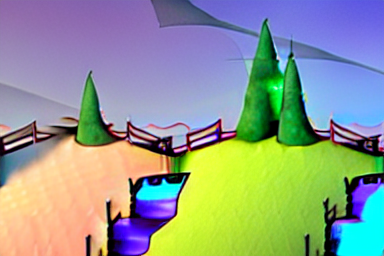

In [6]:
# Final image
output.image

#### 3.1 - Input Saliency Maps

It is now possible to visualize the computed pixel attributions in a saliency map

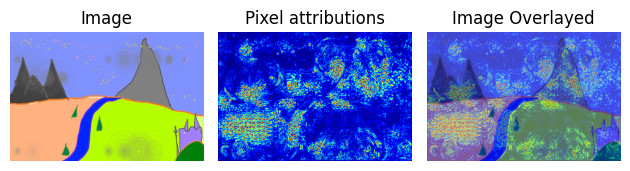

In [7]:
output.input_saliency_map.show(cmap='jet', image_weight=0.5)

Or access the pixel attributions directly

In [8]:
output.pixel_attributions.shape

(256, 384)

In [9]:
output.pixel_attributions

array([[ 0.90722656,  1.7353516 ,  5.0039062 , ...,  8.671875  ,
         5.3554688 ,  3.9589844 ],
       [ 1.6640625 ,  5.3867188 , 12.3046875 , ..., 11.3515625 ,
         5.25      ,  4.71875   ],
       [ 7.2617188 ,  4.28125   , 28.171875  , ..., 52.1875    ,
        28.296875  , 18.578125  ],
       ...,
       [12.8828125 , 13.3046875 , 45.4375    , ..., 74.625     ,
        39.625     , 54.65625   ],
       [ 8.4453125 , 14.46875   , 23.40625   , ..., 44.34375   ,
        36.96875   , 37.96875   ],
       [ 3.0351562 ,  8.859375  , 12.171875  , ..., 37.8125    ,
        13.7421875 , 10.328125  ]], dtype=float32)

Or their normalized version

In [10]:
output.normalized_pixel_attributions

array([[1.72888940e-05, 3.30703624e-05, 9.53587733e-05, ...,
        1.65258753e-04, 1.02058446e-04, 7.54458379e-05],
       [3.17118138e-05, 1.02653976e-04, 2.34488791e-04, ...,
        2.16325207e-04, 1.00048543e-04, 8.99245861e-05],
       [1.38385600e-04, 8.15872045e-05, 5.36867650e-04, ...,
        9.94530157e-04, 5.39249799e-04, 3.54040851e-04],
       ...,
       [2.45506031e-04, 2.53545644e-04, 8.65896349e-04, ...,
        1.42211863e-03, 7.55128276e-04, 1.04157685e-03],
       [1.60941199e-04, 2.75729020e-04, 4.46049758e-04, ...,
        8.45052884e-04, 7.04508508e-04, 7.23565405e-04],
       [5.78405670e-05, 1.68831917e-04, 2.31957805e-04, ...,
        7.20587734e-04, 2.61883019e-04, 1.96821697e-04]], dtype=float32)

#### 3.2 - You still have access to all the features that exist in `StableDiffusionPipelineExplainer`

Here are some examples below. Find out more features in [this notebook](https://colab.research.google.com/github/JoaoLages/diffusers-interpret/blob/main/notebooks/stable_diffusion_example_colab.ipynb).

In [11]:
# (token, attribution_percentage)
output.normalized_token_attributions

[('a', 5.589),
 ('fantasy', 15.466),
 ('landscape', 28.253),
 (',', 6.382),
 ('trending', 13.492),
 ('on', 4.056),
 ('art', 8.243),
 ('station', 18.519)]

In [12]:
# Google Colab does not render the IFrame from the code below, only works locally on your Jupyter Notebook.
output.all_images_during_generation.show(width="100%", height="400px")

###########################################################################################################################
# As an alternative to visualize the produced HTML, run:
import os, shutil, diffusers_interpret
shutil.copy2(os.path.join(os.path.dirname(diffusers_interpret.__file__), "dataviz", "image-slider", "final.html"), '.')

# and open the saved './final.html' manually